In [2]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Day','Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Day','Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

In [4]:
train = pd.read_csv('./data/train/train.csv')

test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp['Day'] = i
    temp = preprocess_data(temp, is_train=False)
    test.append(temp)

df_test = pd.concat(test)

submission = pd.read_csv('./data/sample_submission.csv')

In [5]:
df_train = preprocess_data(train)

df_train.shape, df_test.shape

((52464, 10), (3888, 8))

In [6]:
# http://www.climate.go.kr/home/CCS/contents/help/help_hlthInfo.html 열지수 

df_train['NET'] = 37-(37-df_train['T'])/(0.68-0.0014*df_train.RH+1/(1.76+1.4*df_train.WS**0.75))-0.29*df_train['T']*(1-0.001*df_train.RH)
df_test['NET'] = 37-(37-df_test['T'])/(0.68-0.0014*df_test.RH+1/(1.76+1.4*df_test.WS**0.75))-0.29*df_test['T']*(1-0.001*df_test.RH)

In [7]:
df_train.WS = np.log1p(df_train.WS)
df_test.WS = np.log1p(df_test.WS)

In [8]:
min = df_train[['Day','Hour','DHI','DNI','WS','RH','T', 'NET']].min()
max  = df_train[['Day','Hour','DHI','DNI','WS','RH','T', 'NET']].max()

In [9]:
for i, col in enumerate(['Day','Hour','DHI','DNI','WS','RH','T','NET']):
    df_train[col] = (df_train[col] - min[i]) / (max[i] - min[i])
    df_test[col] = (df_test[col] - min[i]) / (max[i] - min[i])

In [11]:
df_train.columns = ['Day', 'Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T', 'NET'
                    , 'Target1','Target2']

In [12]:
Day0 = df_train.iloc[:, :-2]
Day  = df_train.iloc[:, 1:-2]
Day7 = df_train.iloc[:, -2]
Day8 = df_train.iloc[:, -1]
Day78 = df_train.iloc[:, -2:]

df_test0 = df_test.copy()
df_test = df_test.iloc[:, 1:]

In [13]:
def quantile_loss(q, y, pred):
    err = (y-pred)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [14]:
q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(Day, Day78, test_size=0.25, random_state=42)

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_train.iloc[:, 1:-3], Day7, test_size=0.25, random_state=42)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_train.iloc[:, 1:-3], Day8, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((39348, 8), (13116, 8), (39348, 2), (13116, 2))

In [16]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import mean, maximum

tf.random.set_seed(42)

epoch = 100

In [17]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(Day.shape)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train, Y_train, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
model.evaluate(X_valid, Y_valid)

Epoch 1/100
615/615 [==============================] - 1s 2ms/step - loss: 119.5134 - val_loss: 72.6298
Epoch 2/100
615/615 [==============================] - 1s 1ms/step - loss: 75.9138 - val_loss: 72.9201
Epoch 3/100
615/615 [==============================] - 1s 1ms/step - loss: 72.7681 - val_loss: 70.3387
Epoch 4/100
615/615 [==============================] - 1s 1ms/step - loss: 72.7737 - val_loss: 70.2920
Epoch 5/100
615/615 [==============================] - 1s 1ms/step - loss: 71.3144 - val_loss: 69.5545
Epoch 6/100
615/615 [==============================] - 1s 1ms/step - loss: 72.7803 - val_loss: 69.9297
Epoch 7/100
615/615 [==============================] - 1s 1ms/step - loss: 72.4422 - val_loss: 68.7177
Epoch 8/100
615/615 [==============================] - 1s 1ms/step - loss: 68.9534 - val_loss: 69.6006
Epoch 9/100
615/615 [==============================] - 1s 1ms/step - loss: 72.8756 - val_loss: 67.9434
Epoch 10/100
615/615 [==============================] - 1s 1ms/step - lo

67.66083526611328

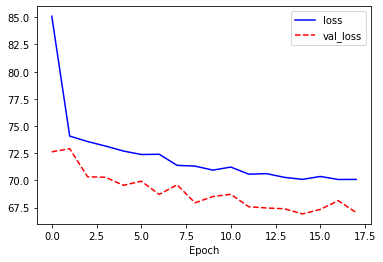

In [18]:
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [19]:
results = pd.DataFrame()

for q in q_lst:
    model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model.fit(Day, Day78, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred = pd.DataFrame(model.predict(df_test))
    results = pd.concat([results, pred], axis=1)

results.shape

Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 0.7458 - val_loss: 0.8123
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7180 - val_loss: 0.8116
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7079 - val_loss: 0.8050
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7036 - val_loss: 0.8033
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7108 - val_loss: 0.8007
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7031 - val_loss: 0.8019
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7061 - val_loss: 0.7991
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7103 - val_loss: 0.8017
Epoch 9/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7071 - val_loss: 0.7946
Epoch 10/100
820/820 [==============================] - 1s 2ms/step - loss: 0.7089 - val_lo

820/820 [==============================] - 2s 2ms/step - loss: 1.3310 - val_loss: 1.4729
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3307 - val_loss: 1.4742
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3183 - val_loss: 1.4689
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3281 - val_loss: 1.5247
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3371 - val_loss: 1.4703
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3073 - val_loss: 1.5060
Epoch 00006: early stopping
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.1997 - val_loss: 1.3212
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 1.1918 - val_loss: 1.3160
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 1.1816 - val_loss: 1.3315
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 

Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 0.4268 - val_loss: 0.4675
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 0.4182 - val_loss: 0.4709
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 0.4145 - val_loss: 0.4649
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 0.4147 - val_loss: 0.4705
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 0.4164 - val_loss: 0.4652
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 0.4119 - val_loss: 0.4607
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 0.4126 - val_loss: 0.4612
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 0.4143 - val_loss: 0.4976
Epoch 9/100
820/820 [==============================] - 1s 1ms/step - loss: 0.4156 - val_loss: 0.4682
Epoch 00009: early stopping


(3888, 18)

In [21]:
from lightgbm import LGBMRegressor

In [54]:
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in q_lst:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=q_lst
    
    return LGBM_models, LGBM_actual_pred

models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, df_test.iloc[:, :-1])
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, df_test.iloc[:, :-1])

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.39392
Early stopping, best iteration is:
[331]	valid_0's quantile: 1.3933
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.19349
Early stopping, best iteration is:
[616]	valid_0's quantile: 2.18579
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.61892
[1000]	valid_0's quantile: 2.57944
[1500]	valid_0's quantile: 2.578
Early stopping, best iteration is:
[1380]	valid_0's quantile: 2.57786
0.4
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.74331
[1000]	valid_0's quantile: 2.70696
[1500]	valid_0's quantile: 2.70093
[2000]	valid_0's quantile: 2.69465
[2500]	valid_0's quantile: 2.68928
[3000]	valid_0's quantile: 2.68205
[3500]	valid_0's quantile: 2.67219
[4000]	valid_0's quantile: 2.66516
[4500]	valid_0's quantile: 2.6608
Early stopping, best iteration is:
[4475]	vali

0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 0.000893508
[1000]	valid_0's quantile: 0.000555658
[1500]	valid_0's quantile: 0.000482467
[2000]	valid_0's quantile: 0.000443767
[2500]	valid_0's quantile: 0.000425862
[3000]	valid_0's quantile: 0.000402065
[3500]	valid_0's quantile: 0.000391383
[4000]	valid_0's quantile: 0.000372051
[4500]	valid_0's quantile: 0.000361298
[5000]	valid_0's quantile: 0.000355457
[5500]	valid_0's quantile: 0.00034803
[6000]	valid_0's quantile: 0.000342256
[6500]	valid_0's quantile: 0.000336791
Early stopping, best iteration is:
[6693]	valid_0's quantile: 0.000336334
0.8
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 0.0010745
[1000]	valid_0's quantile: 0.000428173
[1500]	valid_0's quantile: 0.000335337
[2000]	valid_0's quantile: 0.0003008
[2500]	valid_0's quantile: 0.000285941
[3000]	valid_0's quantile: 0.000274695
[3500]	valid_0's quantile: 0.000267794
[4000]	valid_0's quan

In [23]:
model7 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model7.fit(np.array(Day).reshape(52464, 1, 8), np.array(Day7).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred7 = np.squeeze(model7.predict(np.array(df_test).reshape(3888, 1, 8)))
    pred7 = pd.DataFrame(pred7)
    result7 = pd.concat([result7, pred7], axis=1)
    
result7.shape

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4202 - val_loss: 1.6016
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4161 - val_loss: 1.5978
Epoch 3/100
820/820 [==============================] - 1s 2ms/step - loss: 1.3983 - val_loss: 1.5946
Epoch 4/100
820/820 [==============================] - 1s 2ms/step - loss: 1.3951 - val_loss: 1.5880
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4089 - val_loss: 1.5902
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 1.3930 - val_loss: 1.5994
Epoch 7/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4032 - val_loss: 1.5878
Epoch 8/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4141 - val_loss: 1.5878
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4103 - val_loss: 1.5872
Epoch 10/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4154 - va

Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 1.9305 - val_loss: 2.1412
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 1.9017 - val_loss: 2.1738
Epoch 7/100
820/820 [==============================] - 1s 2ms/step - loss: 1.9356 - val_loss: 2.1513
Epoch 8/100
820/820 [==============================] - 1s 2ms/step - loss: 1.9350 - val_loss: 2.2979
Epoch 9/100
820/820 [==============================] - 1s 2ms/step - loss: 1.9178 - val_loss: 2.1581
Epoch 10/100
820/820 [==============================] - 1s 2ms/step - loss: 1.9290 - val_loss: 2.1449
Epoch 00010: early stopping
0.8
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4215 - val_loss: 1.5874
Epoch 2/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4053 - val_loss: 1.6254
Epoch 3/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4038 - val_loss: 1.5613
Epoch 4/100
820/820 [==============================] - 1s 

(3888, 9)

In [24]:
model8 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model8.fit(np.array(Day).reshape(52464, 1, 8), np.array(Day8).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred8 = np.squeeze(model8.predict(np.array(df_test).reshape(3888, 1, 8)))
    pred8 = pd.DataFrame(pred8)
    result8 = pd.concat([result8, pred8], axis=1)
    
result8.shape

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0249 - val_loss: 0.0108
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0086 - val_loss: 0.0107
Epoch 3/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0039
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 7/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 9/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 10/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0027 - va

820/820 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 5/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 00006: early stopping
0.9
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 2/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 7.4067e-04
Epoch 3/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 9.9496e-04
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 6.9429e-04
Epoch 6/100
820/820 [==============================] - 2s 2

(3888, 9)

In [27]:
model = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[39348, 8]),
    layers.GRU(units=32),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X_train_1).reshape(39348, 1, 8), np.array(Y_train_1).reshape(39348, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
pred = np.squeeze(model8.predict(np.array(X_valid_1).reshape(13116, 1, 8)))

Epoch 1/100
615/615 [==============================] - 4s 4ms/step - loss: 687.1287 - val_loss: 386.8246
Epoch 2/100
615/615 [==============================] - 2s 3ms/step - loss: 332.2592 - val_loss: 239.3902
Epoch 3/100
615/615 [==============================] - 2s 3ms/step - loss: 215.0488 - val_loss: 182.3489
Epoch 4/100
615/615 [==============================] - 2s 3ms/step - loss: 173.0570 - val_loss: 156.2703
Epoch 5/100
615/615 [==============================] - 2s 3ms/step - loss: 152.2415 - val_loss: 145.7618
Epoch 6/100
615/615 [==============================] - 2s 3ms/step - loss: 149.7004 - val_loss: 141.8830
Epoch 7/100
615/615 [==============================] - 2s 4ms/step - loss: 143.4171 - val_loss: 139.1018
Epoch 8/100
615/615 [==============================] - 2s 4ms/step - loss: 136.0239 - val_loss: 135.2523
Epoch 9/100
615/615 [==============================] - 2s 3ms/step - loss: 142.3501 - val_loss: 136.1167
Epoch 10/100
615/615 [==============================] -

In [28]:
model_G7 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 8]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G7.fit(np.array(Day).reshape(52464, 1, 8), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G7 = np.squeeze(model_G7.predict(np.array(df_test).reshape(3888, 1, 8)))
    pred_G7 = pd.DataFrame(pred_G7)
    result_G7 = pd.concat([result_G7, pred_G7], axis=1)
    
result_G7.shape

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5264 - val_loss: 1.6190
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4343 - val_loss: 1.6090
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4109 - val_loss: 1.5932
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3988 - val_loss: 1.5854
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4133 - val_loss: 1.5847
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3967 - val_loss: 1.5823
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4013 - val_loss: 1.5856
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4121 - val_loss: 1.5929
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4106 - val_loss: 1.5765
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4083 - va

0.4
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.7703 - val_loss: 3.0301
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7602 - val_loss: 3.0797
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7313 - val_loss: 3.1064
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7405 - val_loss: 3.1154
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7622 - val_loss: 3.0405
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7125 - val_loss: 3.0583
Epoch 00006: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.6866 - val_loss: 2.9151
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6561 - val_loss: 2.9443
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6426 - val_loss: 2.9262
Epoch 4/100
820/820 [==============================] - 

820/820 [==============================] - 3s 4ms/step - loss: 2.3463 - val_loss: 2.6527
Epoch 14/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3383 - val_loss: 2.5912
Epoch 00014: early stopping
0.7
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.9810 - val_loss: 2.1968
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.9570 - val_loss: 2.1911
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 1.9480 - val_loss: 2.2238
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.9614 - val_loss: 2.1836
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.9620 - val_loss: 2.1902
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.9335 - val_loss: 2.1870
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.9656 - val_loss: 2.1911
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - l

820/820 [==============================] - 3s 3ms/step - loss: 0.8137 - val_loss: 0.9329
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8121 - val_loss: 0.9430
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8182 - val_loss: 0.9407
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8221 - val_loss: 0.9404
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8092 - val_loss: 0.9266
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8110 - val_loss: 0.9099
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8136 - val_loss: 0.9302
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8023 - val_loss: 0.9242
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8105 - val_loss: 0.9207
Epoch 11/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7925 - val_loss: 0.9002


(3888, 9)

In [29]:
model_G8 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 8]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G8.fit(np.array(Day).reshape(52464, 1, 8), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G8 = np.squeeze(model_G8.predict(np.array(df_test).reshape(3888, 1, 8)))
    pred_G8 = pd.DataFrame(pred_G8)
    result_G8 = pd.concat([result_G8, pred_G8], axis=1)
    
result_G8.shape

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5306 - val_loss: 1.6184
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4329 - val_loss: 1.6046
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4104 - val_loss: 1.5952
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3989 - val_loss: 1.5842
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4131 - val_loss: 1.5837
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3961 - val_loss: 1.5819
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4006 - val_loss: 1.5875
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4116 - val_loss: 1.5874
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4101 - val_loss: 1.5749
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4089 - va

820/820 [==============================] - 6s 4ms/step - loss: 2.7877 - val_loss: 3.0346
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7681 - val_loss: 3.1264
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7428 - val_loss: 3.0905
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7485 - val_loss: 3.1285
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7658 - val_loss: 3.0552
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7187 - val_loss: 3.0421
Epoch 00006: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.6952 - val_loss: 2.9288
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6591 - val_loss: 2.9659
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6467 - val_loss: 2.9372
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - lo

820/820 [==============================] - 3s 3ms/step - loss: 1.9517 - val_loss: 2.1666
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.9703 - val_loss: 2.2164
Epoch 11/100
820/820 [==============================] - 3s 3ms/step - loss: 1.9224 - val_loss: 2.1793
Epoch 12/100
820/820 [==============================] - 3s 3ms/step - loss: 1.9619 - val_loss: 2.1894
Epoch 13/100
820/820 [==============================] - 3s 3ms/step - loss: 1.9573 - val_loss: 2.2437
Epoch 14/100
820/820 [==============================] - 3s 3ms/step - loss: 1.9581 - val_loss: 2.1608
Epoch 15/100
820/820 [==============================] - 3s 3ms/step - loss: 1.9662 - val_loss: 2.1983
Epoch 16/100
820/820 [==============================] - 3s 3ms/step - loss: 1.9284 - val_loss: 2.1799
Epoch 17/100
820/820 [==============================] - 3s 3ms/step - loss: 1.9680 - val_loss: 2.1697
Epoch 18/100
820/820 [==============================] - 3s 3ms/step - loss: 1.9336 - val_loss: 

(3888, 9)

In [30]:
epoch = 100

model_M7 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 9]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M7.fit(np.array(Day0).reshape(52464, 1, 9), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M7 = np.squeeze(model_M7.predict(np.array(df_test0).reshape(3888, 1, 9)))
    pred_M7 = pd.DataFrame(pred_M7)
    result_M7 = pd.concat([result_M7, pred_M7], axis=1)
    
result_M7.shape

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5555 - val_loss: 1.6229
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4376 - val_loss: 1.6107
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4104 - val_loss: 1.6004
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3971 - val_loss: 1.5870
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4101 - val_loss: 1.5889
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3922 - val_loss: 1.5791
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3975 - val_loss: 1.5987
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4063 - val_loss: 1.6322
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4065 - val_loss: 1.5726
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4060 - va

820/820 [==============================] - 6s 4ms/step - loss: 2.7798 - val_loss: 3.0802
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7627 - val_loss: 3.1322
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7316 - val_loss: 3.0799
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7440 - val_loss: 3.1781
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7580 - val_loss: 3.0267
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7157 - val_loss: 3.0232
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7647 - val_loss: 3.0351
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7366 - val_loss: 3.0331
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7481 - val_loss: 3.0125
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7636 - val_loss: 3.1043
E

820/820 [==============================] - 6s 4ms/step - loss: 1.5106 - val_loss: 1.6572
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4774 - val_loss: 1.6651
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4675 - val_loss: 1.6647
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4707 - val_loss: 1.6359
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4748 - val_loss: 1.7221
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4494 - val_loss: 1.6568
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4720 - val_loss: 1.6324
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4742 - val_loss: 1.6453
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4505 - val_loss: 1.6306
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4649 - val_loss: 1.6438
E

(3888, 9)

In [31]:
model_M8 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 9]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M8.fit(np.array(Day0).reshape(52464, 1, 9), np.array(Day8).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M8 = np.squeeze(model_M8.predict(np.array(df_test0).reshape(3888, 1, 9)))
    pred_M8 = pd.DataFrame(pred_M8)
    result_M8 = pd.concat([result_M8, pred_M8], axis=1)

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.0224 - val_loss: 0.0068
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0023 - val_loss: 0.0048
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0038
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0022 - va

Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 00005: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.0029 - val_loss: 9.6108e-04
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 00004: early stopping
0.6
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 3/100
820/820 [==

820/820 [==============================] - 5s 4ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 9.3909e-04
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0012 - val_loss: 8.8228e-04
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0016 - val_loss: 9.8618e-04
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 00006: early stopping
0.9
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.0019 - val_loss: 9.3613e-04
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0011 - val_loss: 4.1139e-04
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 7.8458e-04
Epoch 4/100
820/820 [==========================

In [56]:
res_L0 = pd.DataFrame(results_1.sort_index())
res_L0.columns = ['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']
res_L1 = pd.DataFrame(results_2.sort_index())
res_L1.columns = ['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']

res_D0 = pd.DataFrame(results[0].sort_index())
res_D0.columns = ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9']
res_D1 = pd.DataFrame(results[1].sort_index())
res_D1.columns = ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9']

res_C0 = pd.DataFrame(result7.sort_index())
res_C0.columns = ['C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9']
res_C1 = pd.DataFrame(result8.sort_index())
res_C1.columns = ['C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9']

res_G0 = pd.DataFrame(result_G7.sort_index())
res_G0.columns = ['G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9']
res_G1 = pd.DataFrame(result_G8.sort_index())
res_G1.columns = ['G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9']

res_M0 = pd.DataFrame(result_M7.sort_index())
res_M0.columns = ['M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9']
res_M1 = pd.DataFrame(result_M8.sort_index())
res_M1.columns = ['M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9']

In [57]:
res_0 = pd.DataFrame()
res_1= pd.DataFrame()
res_0 = pd.concat([res_L0, res_D0, res_C0, res_G0, res_M0], axis=1)
res_1 = pd.concat([res_L1, res_D1, res_C1, res_G1, res_M1], axis=1)

In [59]:
res_0[:48]

,L00.1,L00.2,L00.3,L00.4,L00.5,L00.6,L00.7,L00.8,L00.9,D00.1,...,G00.9,M00.1,M00.2,M00.3,M00.4,M00.5,M00.6,M00.7,M00.8,M00.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.273425,...,0.755528,0.118294,0.259558,0.294259,0.357403,0.504648,0.604929,0.969028,1.132012,1.086461
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.267820,...,0.755096,0.115288,0.252617,0.286477,0.346335,0.490296,0.590949,0.956994,1.123215,1.073405
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.260997,...,0.814927,0.104219,0.234425,0.274159,0.337055,0.481307,0.591273,0.987017,1.300788,1.398957
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.264772,...,0.816520,0.106566,0.239561,0.280026,0.345779,0.492650,0.602674,0.996329,1.303194,1.403417
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.263677,...,0.892494,0.098421,0.228748,0.276130,0.347792,0.497638,0.615344,1.035321,1.502375,1.808987
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.253416,...,0.894501,0.093968,0.217455,0.261989,0.326934,0.470699,0.588762,1.011349,1.485668,1.776501
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.246107,...,1.008210,0.084636,0.202195,0.250823,0.317235,0.460153,0.585064,1.031755,1.676874,2.207006
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.226880,...,1.007337,0.075551,0.179572,0.222169,0.274269,0.403619,0.526450,0.972316,1.638593,2.133951
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.210393,...,1.160495,0.063257,0.155097,0.196929,0.241697,0.362012,0.487632,0.947327,1.797687,2.541737
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.195568,...,1.153129,0.057941,0.140788,0.178586,0.215343,0.325937,0.447538,0.890771,1.714657,2.389091


In [62]:
res_0.loc[res_0[res_0['L00.1'] == 0].index, ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9'
                                            ,'C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9'
                                            ,'G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9'
                                            ,'M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9'
                                            ]] = 0
res_1.loc[res_1[res_0['L00.1'] == 0].index, ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9'
                                            ,'C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9'
                                            ,'G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9'
                                            ,'M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9'
                                            ]] = 0

In [67]:
res_1[:48].to_csv('1.csv', index=False)

In [65]:
for i in range(1, 10):
    res_0["L00."+str(i)] = (res_0["L00."+str(i)] + res_0["D00."+str(i)] + res_0["C00."+str(i)] + res_0["G00."+str(i)] + res_0["M00."+str(i)])/5
    res_1["L10."+str(i)] = (                    res_1["D10."+str(i)] + res_1["C10."+str(i)] + res_1["G10."+str(i)] + res_1["M10."+str(i)])/4

In [66]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = res_0[['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']].values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = res_1[['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']].values
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [68]:
submission.to_csv('./submission/submission_20210123-2.csv', index=False)